<a href="https://colab.research.google.com/github/vmendesmagalhaes/machine-learning/blob/main/Prediction_of_the_moisture_content_variation_on_wood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of the moisture content variation on wood

**Author:** Vitor Mendes Magalhaes

**Email:** vitor.mendes.magalhaes@gmail.com

**Last review:** Jun/2023

Wood is the raw material for many manufactured goods. Charcoal, cellulose for the paper industry, laminated wood furniture, and even explosive products, such as gunpowder cotton, are possible destinations for the wood. On the other hand, the growing use of wood as a raw material has increased illegal deforestation and, as a direct consequence, it has changed the climate at a global level.

Regardless of the destination that will be given to the wood logs, many products that have wood as raw material go through the same stage: the storage of logs in piles.

But as the storage time on piles passes, the moisture content on wood will reduce.

The use of wood in production processes must be optimized to mitigate these adverse effects. One of the determining factors for this optimization is moisture content on wood, i.e., the ratio between the mass of water contained in the wood and dry wood mass.

Here, we develop a Artificial Intelligence-based model - specifically using machine learning classification and regression methods - to predict the moisture content on wood, contributing to a better use of the wood in industry.

Let's start by loading the necessary libraries for solving the present applied research problem.

In [ ]:
import pandas as pandas
import numpy as numpy
import matplotlib.pyplot as plt
from numpy import absolute
from numpy import std
from numpy import mean
from sklearn.model_selection import train_test_split as createDataPartition
from sklearn.preprocessing import LabelEncoder

import os
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from scipy.stats import friedmanchisquare
!pip install pingouin
import pingouin as pg

import warnings
warnings.filterwarnings('ignore')

The very first step is to import the spreadsheet (.XLS file) containing the raw data.

In [ ]:
dados = pandas.read_excel('datasetjan23.xls')

Now we have the data, let's start working on it.

First, let's create a new attribute, called *PERCENTUAL*. It means the percentage of weight loss in relation to the total amount of incoming wood logs in each pile.

In [ ]:
dados['PERCENTUAL'] = (dados['ESTORNO'] * 100) / dados['TOT_ENTR']

After creating the new attribute, we will remove the instances of piles that didn't have log outputs (in theory, if they do not represent an operational error, these piles continued to receive loads of wood, or were not yet closed, at the time of data capture).

We will also remove instances of piles that have not had reversed charges, that is, that in theory there was no loss of moisture. In the case of wood logs stored outdoors (technically, it is called "natural drying"), under the conditions of the captured data, there will always be moisture loss.

In [ ]:
dados.drop(dados[dados['TOT_SAID'] == 0].index, inplace=True)
dados.drop(dados[dados['ESTORNO'] == 0].index, inplace=True)

After removing the instances, let's create a copy of the original dataset, which will be used to train different problem solving models using supervised learning. We will train classification models.

In [ ]:
dfClassificacao = dados

Now, let's start the pre-processing step, removing the attributes that are not interesting for creating the learning models to be applied.

Once this is done, we will continue pre-processing the data, now with a selection of features, removing attributes and biasing the data to conform to the type of supervised learning they propose.

For the development of the classification models, let's create a new attribute, called *INTERVALOPERDA*, meaning the loss ranges. Loss ranges are nothing more than weight loss percentage ranges, eg between 0% and 5% loss; between 5% and 10% loss, and so on, as far as the data allows.

To define the best weight loss percentage ranges, we will first analyze visually, using three different visual analysis tools: a *boxplot*, a summary of the *PERCENTUAL* attribute (which will dictate the ranges), and a histogram with the frequency of instances with different percentages.

<Axes: >

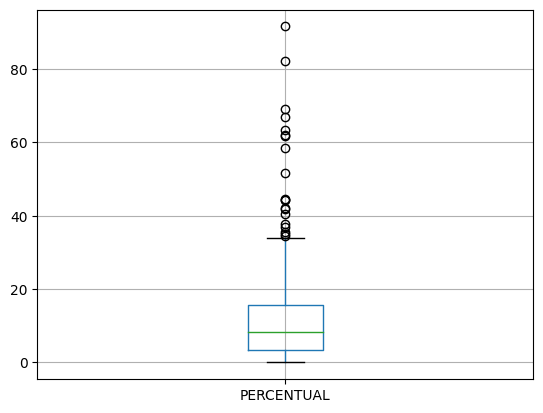

In [ ]:
dfClassificacao.boxplot(column =['PERCENTUAL'], grid = True)

<Axes: >

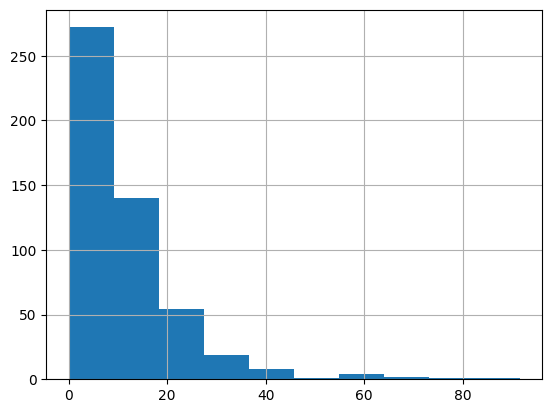

In [ ]:
dfClassificacao['PERCENTUAL'].hist()

In [ ]:
dfClassificacao.describe()

,PILHA,COMPRIMENTO,TEMP_MIN,TEMP_MAX,TEMP_MED,TEMP_PO,PRECIPITACAO,PATM_MED,UR_MIN,UR_MED,VENTO_MED,RAJ_MAX_MED,QTD_DIAS,TOT_ENTR,TOT_SAID,DIFERENCA,ESTORNO,PERCENTUAL
count,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,5.020000e+02,5.020000e+02,5.020000e+02,5.020000e+02,502.000000
mean,380.834661,5.191633,6.353386,30.933068,17.668108,13.021813,230.048207,1015.596673,29.844622,75.807032,3.020159,10.148426,82.864542,2.955402e+05,2.608087e+05,3.473146e+04,3.217752e+04,11.404791
std,201.004887,0.380277,4.468436,6.301451,3.514570,2.811104,204.907322,2.839966,9.870406,4.102414,0.423014,1.044224,70.283867,4.209043e+05,3.530809e+05,8.307838e+04,7.519074e+04,11.723297
min,1.000000,3.900000,1.900000,18.100000,11.640000,6.380000,0.000000,1005.890000,21.000000,64.360000,1.430000,5.700000,0.000000,1.144000e+04,3.030000e+03,-1.996000e+04,2.000000e+01,0.005657
25%,209.250000,5.200000,3.300000,26.700000,14.965000,11.017500,41.400000,1013.885000,21.000000,71.902500,2.700000,9.480000,22.000000,1.312050e+05,1.127950e+05,6.310000e+03,6.310000e+03,3.414372
50%,381.500000,5.200000,5.400000,32.500000,17.395000,12.805000,184.300000,1016.310000,26.000000,76.105000,3.155000,10.440000,69.000000,2.329100e+05,2.047900e+05,1.883000e+04,1.746000e+04,8.179170
75%,556.750000,5.200000,8.600000,34.400000,20.377500,14.797500,392.200000,1016.920000,36.000000,79.260000,3.260000,10.660000,133.750000,3.658750e+05,3.268445e+05,3.958000e+04,3.842550e+04,15.792322
max,722.000000,6.000000,24.000000,39.400000,26.930000,23.340000,1156.000000,1026.700000,70.000000,84.670000,4.630000,14.300000,425.000000,8.128820e+06,6.628260e+06,1.500560e+06,1.500560e+06,91.583333


In a brief analysis, it is noticed that there are possible operational errors that can generate noise in the classification model, allowing them to be considered outliers.

A clear example is the loss percentage. There are percentages that tend to 100%, which does not occur in this process; there are also percentages that tend to 0% - same situation.

So let's remove the instances with losses above 40%.

In [ ]:
dfClassificacao = dfClassificacao.drop(dfClassificacao[dados['PERCENTUAL'] >= 40].index)

Afterwards, let's check again through the *boxplot*.

<Axes: >

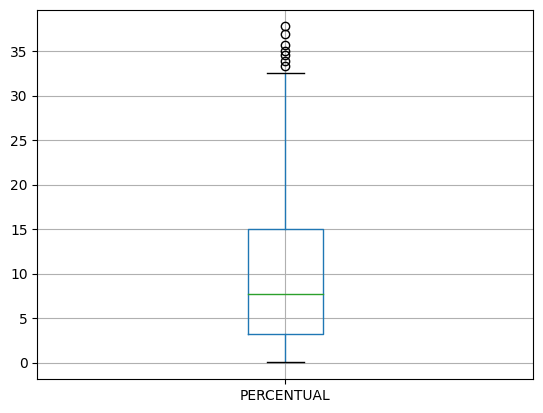

In [ ]:
dfClassificacao.boxplot(column =['PERCENTUAL'], grid = True)

Now we can return to the creation of the attribute *INTERVALOPERDA*, establishing different intervals of loss percentages:

CLASS | INTERVAL
--- | ---
1 | less than 10%
2 | between 10% and 20%
3 | between 20% and 30%
4 | more than 30%

In [ ]:
for i, linha in dfClassificacao.iterrows():
  if (linha['PERCENTUAL'] <= 10):
    dfClassificacao.loc[i, 'INTERVALOPERDA'] = 1;
  elif ((linha['PERCENTUAL'] > 10) and (linha['PERCENTUAL'] <= 20)):
    dfClassificacao.loc[i, 'INTERVALOPERDA'] = 2;
  elif ((linha['PERCENTUAL'] > 20) and (linha['PERCENTUAL'] <= 30)):
    dfClassificacao.loc[i, 'INTERVALOPERDA'] = 3;
  else:
    dfClassificacao.loc[i, 'INTERVALOPERDA'] = 4;

Once the *INTERVALOPERDA* attribute is created, let's remove the attributes that will not be important for the creation of the learning models - more specifically, the classification.

In this sense, we will remove the stack identification (*PILHA*), the dates (*DATA_INICIO* and *DATA_FIM*, the output weight (*TOT_SAID*), the difference between the input and output totals (*DIFERENCA*) , the amount reversed (*ESTORNO*) and the percentage (*PERCENTUAL*).

Thus, we make it clear that the class we want to predict is the *INTERVALOPERDA*, just created, which contains the interval (in percentage) of wood weight loss.

In [ ]:
dfClassificacao = dfClassificacao.drop(["PILHA", "DATA_INICIO", "DATA_FIM", "TOT_SAID", "DIFERENCA", "ESTORNO", "PERCENTUAL"], axis=1)

After creating the attribute (class) that will be our target, and removing the attributes that will not be predictors of our models, we will check the balance of the dataset.

In [ ]:
print(dfClassificacao['INTERVALOPERDA'].value_counts())

1.0    288
2.0    142
3.0     43
4.0     14
Name: INTERVALOPERDA, dtype: int64


We can clearly observe that the largest number of instances is represented in classes 1 and 2, that is, the vast majority of the piles present in the dataset have a weight loss (due to the loss of moisture content) of less than 20%.

We will verify the integrity of these data, analyzing the moisture losses from the piles in relation to the number of days that the logs remained stored (in the same piles).

In [ ]:
print(dfClassificacao['QTD_DIAS'].describe())

count    487.000000
mean      81.266940
std       68.858645
min        0.000000
25%       22.000000
50%       68.000000
75%      127.000000
max      425.000000
Name: QTD_DIAS, dtype: float64


Considering, then, that when it comes to loss of moisture content in wood stored outdoors (*natural drying*) 20% is a small percentage, it can be easily inferred that these logs, due to the large number of days average battery life (81 days), had already been cut longer.

As there are non-numeric predictor attributes, we need to treat them, transforming them into numerical attributes so that we can proceed with the training of the learning models (in Weka, in R and in other environments/languages, this transformation is not necessary, but it is need to analyze possible differences in the prediction result).

Let's do the *one-hot-encoding* for categorical attributes that don't have any need for sorting, like product, bark, and species.

In [ ]:
atributos_a_codificar = ['PRODUTO', 'CASCA', 'ESPECIE', 'DIAMETRO']

atributos_codificados = pandas.get_dummies(dfClassificacao[atributos_a_codificar])

dfClassificacao = dfClassificacao.drop(atributos_a_codificar, axis=1).join(atributos_codificados)

Before the next step, it's time to remove the class (*INTERVALOPERDA* attritube) and prepare the dataset to be splitted.

In [ ]:
dfClassificacaoTrain = dfClassificacao.drop(["INTERVALOPERDA"], axis=1)

The dataset has not yet been partitioned. The tendency is for the partitions to reproduce the general behavior of the dataset.

But since we want to create generalists prediction models, that is, models that can be applied to any business that has the same data available, we need to test the created models several times and also apply some statistic tests.

Before that, we need to ensure the reproducibility of the experiment. Let's do this by setting some seeds. We decided to create 10 different seeds, so that our data will be chosen differently in 10 consecutive times. Such creation will help us to verify through some metrics that will allow us to carry out more in-depth statistical analysis.

First, let's create the 10 seeds.

In [ ]:
lista_seeds = [1, 10, 100, 500, 1000, 10000, 50000, 100000, 500000, 1000000]

The next step is to iterate between the different seeds, partitioning the dataset with 80% of the data separated for training, and 20% for testing.

For each data, we instantiate the classification models using some algorithms. We will use *Random Forest* (RF), *Logistic Regression* (LR), *Support Vector Machines* (SVM), *Gaussian Naive Bayes* (NB), *AdaBoost* (AB), *Gradient Boost* (GB) and *Multi-Layer Perceptrons* (MLP).

In [ ]:
dados_treino, dados_teste, classe_treino, classe_teste = {}
rf, lr, csvm, nb, ab, gb, mlp = {}

for seed in lista_seeds:
    dados_treino[seed], dados_teste[seed], classe_treino[seed], classe_teste[seed] = createDataPartition(dfClassificacaoTrain, dfClassificacao['INTERVALOPERDA'], test_size=0.2, random_state=seed)

    rf[seed] = RandomForestClassifier()
    lr[seed] = LogisticRegression()
    csvm[seed] = svm.LinearSVC()
    nb[seed] = GaussianNB()
    ab[seed] = AdaBoostClassifier()
    gb[seed] = GradientBoostingClassifier()
    mlp[seed] = MLPClassifier()

Once the models are instantiated, we will train the classification model with the data already biased towards supervised learning - classification. After the training step (using both the training data and the training class), the next step is to verify the predictions, that is, what in fact the created models were able to learn from the available data.

In [ ]:
predicoes_rf, predicoes_lr, predicoes_svm, predicoes_nb, predicoes_ab, predicoes_gb, predicoes_mlp = {}

for seed in lista_seeds:
    rf.fit(dados_treino[seed], classe_treino[seed])
    lr.fit(dados_treino[seed], classe_treino[seed])
    csvm.fit(dados_treino[seed], classe_treino[seed])
    nb.fit(dados_treino[seed], classe_treino[seed])
    ab.fit(dados_treino[seed], classe_treino[seed])
    gb.fit(dados_treino[seed], classe_treino[seed])
    mlp.fit(dados_treino[seed], classe_treino[seed])

    predicoes_rf[seed] = rf[seed].predict(dados_teste[seed])
    predicoes_lr[seed] = lr[seed].predict(dados_teste[seed])
    predicoes_svm[seed] = csvm[seed].predict(dados_teste[seed])
    predicoes_nb[seed] = nb[seed].predict(dados_teste[seed])
    predicoes_ab[seed] = ab[seed].predict(dados_teste[seed])
    predicoes_gb[seed] = gb[seed].predict(dados_teste[seed])
    predicoes_mlp[seed] = mlp[seed].predict(dados_teste[seed])

After that, we need to create the arrays that will save the evaluation metrics (accuracy¹, precision, recall and F1-score) of each generated model in an array, to test it later. We also will save the classification report and the confusion matrix of each generated model.

¹ it is important to keep in mind that, although accuracy is the proportion of correct predictions in relation to the total number of predictions, it is a simple metric, that is, it may not always be the most suitable metric - especially in unbalanced datasets (like this one).

Finally, after that, we save the evaluation metrics into the (already created) arrays.

In [ ]:
accuracy_default, precision_default, recall_default, f1_default = {}
cm_default, clasreport_default = {}

for seed in lista_seeds:
    cm_default[seed] = {
        'Random Forest': confusion_matrix(classe_teste[seed], predicoes_rf[seed]),
        'Logistic Regression': confusion_matrix(classe_teste[seed], predicoes_lr[seed]),
        'Linear SVM': confusion_matrix(classe_teste[seed], predicoes_svm[seed]),
        'Gaussian Naive Bayes': confusion_matrix(classe_teste[seed], predicoes_nb[seed]),
        'AdaBoost': confusion_matrix(classe_teste[seed], predicoes_ab[seed]),
        'Gradient Boosting': confusion_matrix(classe_teste[seed], predicoes_gb[seed]),
        'MLP': confusion_matrix(classe_teste[seed], predicoes_mlp[seed])
    }

    clasreport_default[seed] = {
        'Random Forest': classification_report(classe_teste[seed], predicoes_rf[seed]),
        'Logistic Regression': classification_report(classe_teste[seed], predicoes_lr[seed]),
        'Linear SVM': classification_report(classe_teste[seed], predicoes_svm[seed]),
        'Gaussian Naive Bayes': classification_report(classe_teste[seed], predicoes_nb[seed]),
        'AdaBoost': classification_report(classe_teste[seed], predicoes_ab[seed]),
        'Gradient Boosting': classification_report(classe_teste[seed], predicoes_gb[seed]),
        'MLP': classification_report(classe_teste[seed], predicoes_mlp[seed])
    }

    accuracy_default[seed] = {
        'Random Forest': accuracy_score(classe_teste[seed], predicoes_rf[seed]),
        'Logistic Regression': accuracy_score(classe_teste[seed], predicoes_lr[seed]),
        'Linear SVM': accuracy_score(classe_teste[seed], predicoes_svm[seed]),
        'Gaussian Naive Bayes': accuracy_score(classe_teste[seed], predicoes_nb[seed]),
        'AdaBoost': accuracy_score(classe_teste[seed], predicoes_ab[seed]),
        'Gradient Boosting': accuracy_score(classe_teste[seed], predicoes_gb[seed]),
        'MLP': accuracy_score(classe_teste[seed], predicoes_mlp[seed])
    }

    precision_default[seed] = {
        'Random Forest': precision_score(classe_teste[seed], predicoes_rf[seed], average='weighted'),
        'Logistic Regression': precision_score(classe_teste[seed], predicoes_lr[seed], average='weighted'),
        'Linear SVM': precision_score(classe_teste[seed], predicoes_svm[seed], average='weighted'),
        'Gaussian Naive Bayes': precision_score(classe_teste[seed], predicoes_nb[seed], average='weighted'),
        'AdaBoost': precision_score(classe_teste[seed], predicoes_ab[seed], average='weighted'),
        'Gradient Boosting': precision_score(classe_teste[seed], predicoes_gb[seed], average='weighted'),
        'MLP': precision_score(classe_teste[seed], predicoes_mlp[seed], average='weighted')
    }

    recall_default[seed] = {
        'Random Forest': recall_score(classe_teste[seed], predicoes_rf[seed], average='weighted'),
        'Logistic Regression': recall_score(classe_teste[seed], predicoes_lr[seed], average='weighted'),
        'Linear SVM': recall_score(classe_teste[seed], predicoes_svm[seed], average='weighted'),
        'Gaussian Naive Bayes': recall_score(classe_teste[seed], predicoes_nb[seed], average='weighted'),
        'AdaBoost': recall_score(classe_teste[seed], predicoes_ab[seed], average='weighted'),
        'Gradient Boosting': recall_score(classe_teste[seed], predicoes_gb[seed], average='weighted'),
        'MLP': recall_score(classe_teste[seed], predicoes_mlp[seed], average='weighted')
    }

    f1_default[seed] = {
        'Random Forest': f1_score(classe_teste[seed], predicoes_rf[seed], average='weighted'),
        'Logistic Regression': f1_score(classe_teste[seed], predicoes_lr[seed], average='weighted'),
        'Linear SVM': f1_score(classe_teste[seed], predicoes_svm[seed], average='weighted'),
        'Gaussian Naive Bayes': f1_score(classe_teste[seed], predicoes_nb[seed], average='weighted'),
        'AdaBoost': f1_score(classe_teste[seed], predicoes_ab[seed], average='weighted'),
        'Gradient Boosting': f1_score(classe_teste[seed], predicoes_gb[seed], average='weighted'),
        'MLP': f1_score(classe_teste[seed], predicoes_mlp[seed], average='weighted')
    }

The next step is similar to the previous one, but we will tune the hyperparamethers of each algorithm in order to find better results. To find the best tuning that is possible, we will use the GridSearchCV library.

At first, we will stablish an universe of possibilities (different values) for each hyperparamether of each algorithm.

In [ ]:
gridCV_rf = {
  	'n_estimators': [5, 10, 100],
		'max_features': ['sqrt', 'log2'],
		'max_depth': [5, 10, 15],
		'max_leaf_nodes': [3, 9, 15]
}

gridCV_lr = {
		'C': [0.1, 1, 100],
		'max_iter': [100, 1000, 100000],
		'multi_class': ['auto', 'ovr', 'multinomial']
}

gridCV_svm = {
		'C': [0.1, 1, 100],
		'max_iter': [100, 1000, 50000]
}

gridCV_naivebyes = {
		'var_smoothing': numpy.logspace(0,-9, num=100)
}

gridCV_adaboost = {
  	'n_estimators': [1, 10, 100],
		'algorithm': ['SAMME', 'SAMME.R']
}

gridCV_gradientboost = {
  	'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5],
		'max_depth': [3, 9, 15],
		'n_estimators': [1, 10, 100]
}

gridCV_MLP = {
		'max_iter': [100, 1000, 10000],
  	'hidden_layer_sizes': [(150, 100, 50), (40, 80, 120), (100, 150, 30), (50, 50, 50)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'learning_rate': ['constant', 'adaptive']
}

At this point, we are ready to iterate again between the seeds, finding the best tuning of each hyperparamether, of each algorithm, on each seed.

Having the best tuning options for each algorithm, it's time to develop the models taking these hyperparameters as training-rules. We will do this by training again our models, but now with the best tune option, given by the GridSearchCV.

After that, we will save the best tuning into an array.


In [ ]:
best_tuning_default = {}
grid_rf, grid_lr, grid_svm, grid_nb, grid_ab, grid_gb, grid_mlp = {}

for seed in lista_seeds:
    grid_rf[seed] = GridSearchCV(rf[seed], param_grid=gridCV_rf, cv=5)
    grid_lr[seed] = GridSearchCV(lr[seed], param_grid=gridCV_lr, cv=5)
    grid_svm[seed] = GridSearchCV(csvm[seed], param_grid=gridCV_svm, cv=5)
    grid_nb[seed] = GridSearchCV(nb[seed], param_grid=gridCV_naivebyes, cv=5)
    grid_ab[seed] = GridSearchCV(ab[seed], param_grid=gridCV_adaboost, cv=5)
    grid_gb[seed] = GridSearchCV(gb[seed], param_grid=gridCV_gradientboost, cv=5)
    grid_mlp[seed] = GridSearchCV(mlp[seed], param_grid=gridCV_MLP, cv=5)

    grid_rf[seed].fit(dados_treino[seed], classe_treino[seed])
    grid_lr[seed].fit(dados_treino[seed], classe_treino[seed])
    grid_svm[seed].fit(dados_treino[seed], classe_treino[seed])
    grid_nb[seed].fit(dados_treino[seed], classe_treino[seed])
    grid_ab[seed].fit(dados_treino[seed], classe_treino[seed])
    grid_gb[seed].fit(dados_treino[seed], classe_treino[seed])
    grid_mlp[seed].fit(dados_treino[seed], classe_treino[seed])

    best_tuning_default[seed] = {
        'Random Forest': grid_rf[seed].best_estimator_,
        'Logistic Regression': grid_lr[seed].best_estimator_,
        'Linear SVM': grid_svm[seed].best_estimator_,
        'Gaussian Naive Bayes': grid_nb[seed].best_estimator_,
        'AdaBoost': grid_ab[seed].best_estimator_,
        'Gradient Boosting': grid_gb[seed].best_estimator_,
        'MLP': grid_mlp[seed].best_estimator_
    }

At this point, we already know the best tune of each one. So, let's train again our models, giving it the option to know its best hyperparamethers and set them.

In [ ]:
rf_tuned, lr_tuned, csvm_tuned, nb_tuned, ab_tuned, gb_tuned, mlp_tuned = {}

for seed in lista_seeds:
    rf_tuned[seed] = grid_rf[seed].best_estimator_
    lr_tuned[seed] = grid_lr[seed].best_estimator_
    csvm_tuned[seed] = grid_svm[seed].best_estimator_
    nb_tuned[seed] = grid_nb[seed].best_estimator_
    ab_tuned[seed] = grid_ab[seed].best_estimator_
    gb_tuned[seed] = grid_gb[seed].best_estimator_
    mlp_tuned[seed] = grid_mlp[seed].best_estimator_

    rf_tuned[seed].fit(dados_treino[seed], classe_treino[seed])
    lr_tuned[seed].fit(dados_treino[seed], classe_treino[seed])
    csvm_tuned[seed].fit(dados_treino[seed], classe_treino[seed])
    nb_tuned[seed].fit(dados_treino[seed], classe_treino[seed])
    ab_tuned[seed].fit(dados_treino[seed], classe_treino[seed])
    gb_tuned[seed].fit(dados_treino[seed], classe_treino[seed])
    mlp_tuned[seed].fit(dados_treino[seed], classe_treino[seed])

After that, we will get the predictions of each model (setup default-tuned) for each seed.

In [ ]:
predicoes_rf_tuned, predicoes_lr_tuned, predicoes_svm_tuned, predicoes_nb_tuned, predicoes_ab_tuned, predicoes_gb_tuned, predicoes_mlp_tuned = {}

for seed in lista_seeds:
    predicoes_rf_tuned[seed] = rf_tuned[seed].predict(dados_teste[seed])
    predicoes_lr_tuned[seed] = lr_tuned[seed].predict(dados_teste[seed])
    predicoes_svm_tuned[seed] = csvm_tuned[seed].predict(dados_teste[seed])
    predicoes_nb_tuned[seed] = nb_tuned[seed].predict(dados_teste[seed])
    predicoes_ab_tuned[seed] = ab_tuned[seed].predict(dados_teste[seed])
    predicoes_gb_tuned[seed] = gb_tuned[seed].predict(dados_teste[seed])
    predicoes_mlp_tuned[seed] = mlp_tuned[seed].predict(dados_teste[seed])

Now, we will save the evaluation metrics of the tuned models.

In [ ]:
cm_default_tuned, clasreport_default_tuned = {}
accuracy_default_tuned, precision_default_tuned, recall_default_tuned, f1_default_tuned = {}

for seed in lista_seeds:
    cm_default_tuned[seed] = {
        'Random Forest': confusion_matrix(classe_teste[seed], predicoes_rf_tuned[seed]),
        'Logistic Regression': confusion_matrix(classe_teste[seed], predicoes_lr_tuned[seed]),
        'Linear SVM': confusion_matrix(classe_teste[seed], predicoes_svm_tuned[seed]),
        'Gaussian Naive Bayes': confusion_matrix(classe_teste[seed], predicoes_nb_tuned[seed]),
        'AdaBoost': confusion_matrix(classe_teste[seed], predicoes_ab_tuned[seed]),
        'Gradient Boosting': confusion_matrix(classe_teste[seed], predicoes_gb_tuned[seed]),
        'MLP': confusion_matrix(classe_teste[seed], predicoes_mlp_tuned[seed])
    }

    clasreport_default_tuned[seed] = {
        'Random Forest': classification_report(classe_teste[seed], predicoes_rf_tuned[seed]),
        'Logistic Regression': classification_report(classe_teste[seed], predicoes_lr_tuned[seed]),
        'Linear SVM': classification_report(classe_teste[seed], predicoes_svm_tuned[seed]),
        'Gaussian Naive Bayes': classification_report(classe_teste[seed], predicoes_nb_tuned[seed]),
        'AdaBoost': classification_report(classe_teste[seed], predicoes_ab_tuned[seed]),
        'Gradient Boosting': classification_report(classe_teste[seed], predicoes_gb_tuned[seed]),
        'MLP': classification_report(classe_teste[seed], predicoes_mlp_tuned[seed])
    }

    accuracy_default_tuned[seed] = {
        'Random Forest': accuracy_score(classe_teste[seed], predicoes_rf_tuned[seed]),
        'Logistic Regression': accuracy_score(classe_teste[seed], predicoes_lr_tuned[seed]),
        'Linear SVM': accuracy_score(classe_teste[seed], predicoes_svm_tuned[seed]),
        'Gaussian Naive Bayes': accuracy_score(classe_teste[seed], predicoes_nb_tuned[seed]),
        'AdaBoost': accuracy_score(classe_teste[seed], predicoes_ab_tuned[seed]),
        'Gradient Boosting': accuracy_score(classe_teste[seed], predicoes_gb_tuned[seed]),
        'MLP': accuracy_score(classe_teste[seed], predicoes_mlp_tuned[seed])
    }

    precision_default_tuned[seed] = {
        'Random Forest': precision_score(classe_teste[seed], predicoes_rf_tuned[seed], average='weighted'),
        'Logistic Regression': precision_score(classe_teste[seed], predicoes_lr_tuned[seed], average='weighted'),
        'Linear SVM': precision_score(classe_teste[seed], predicoes_svm_tuned[seed], average='weighted'),
        'Gaussian Naive Bayes': precision_score(classe_teste[seed], predicoes_nb_tuned[seed], average='weighted'),
        'AdaBoost': precision_score(classe_teste[seed], predicoes_ab_tuned[seed], average='weighted'),
        'Gradient Boosting': precision_score(classe_teste[seed], predicoes_gb_tuned[seed], average='weighted'),
        'MLP': precision_score(classe_teste[seed], predicoes_mlp_tuned[seed], average='weighted')
    }

    recall_default_tuned[seed] = {
        'Random Forest': recall_score(classe_teste, predicoes_rf_tuned, average='weighted'),
        'Logistic Regression': recall_score(classe_teste, predicoes_lr_tuned, average='weighted'),
        'Linear SVM': recall_score(classe_teste, predicoes_svm_tuned, average='weighted'),
        'Gaussian Naive Bayes': recall_score(classe_teste, predicoes_nb_tuned, average='weighted'),
        'AdaBoost': recall_score(classe_teste, predicoes_ab_tuned, average='weighted'),
        'Gradient Boosting': recall_score(classe_teste, predicoes_gb_tuned, average='weighted'),
        'MLP': recall_score(classe_teste, predicoes_mlp_tuned, average='weighted')
    }

    f1_default_tuned [seed] = {
        'Random Forest': f1_score(classe_teste[seed], predicoes_rf_tuned[seed], average='weighted'),
        'Logistic Regression': f1_score(classe_teste[seed], predicoes_lr_tuned[seed], average='weighted'),
        'Linear SVM': f1_score(classe_teste[seed], predicoes_svm_tuned[seed], average='weighted'),
        'Gaussian Naive Bayes': f1_score(classe_teste[seed], predicoes_nb_tuned[seed], average='weighted'),
        'AdaBoost': f1_score(classe_teste[seed], predicoes_ab_tuned[seed], average='weighted'),
        'Gradient Boosting': f1_score(classe_teste[seed], predicoes_gb_tuned[seed], average='weighted'),
        'MLP': f1_score(classe_teste[seed], predicoes_mlp_tuned[seed], average='weighted')
    }

The next step is about solving the imbalance problem of the dataset and take a look again. To better evaluate our models, we have to test them into a balanced dataset, inserting synthetic instances on it. Let's use the SMOTE library to handle with it.

It's important to notice that the process of balancing datasets has some troubles dealing with the categorical attributes. We have to solve it before going ahead. We used the one-hot encoding approach to deal with the categorical data. It roughly turns the categorical possibilities into columns, with binary values, 0 and 1.

The SMOTE algorithm treated these attributes as numerical rather than categorical, and so, instead of filling in values 0 or 1, it fills the synthetic instances with values between 0 and 1 (0,73, e.g.). To solve this, we'll use the following strategy: we'll iterate over each categorical column that we've performed the one-hot-encoding (PRODUTO, CASCA, ESPECIE and DIAMETRO), looking for the highest value for each one of them. The column with the highest value will be replaced by the value 1, and the others will be replaced by the value 0.

This way, we keep the original characteristics of the dataset closer, even after the classes are unbalanced, forcing SMOTE to work only with numerical attributes.

After that, we will train our models with the balanced data, without tuning the hyperparamethers, and get its predictions.

In [ ]:
rf_balanced, lr_balanced, svm_balanced, nb_balanced, ab_balanced, gb_balanced, mlp_balanced = {}
predicoes_balanced_rf, predicoes_balanced_lr, predicoes_balanced_svm, predicoes_balanced_nb, predicoes_balanced_ab, predicoes_balanced_gb, predicoes_balanced_mlp = {}

produtos = ['PRODUTO_EUCALYPTUS', 'PRODUTO_PINUS']
cascas = ['CASCA_NO', 'CASCA_YES']
especies = ['ESPECIE_DUNNII', 'ESPECIE_ELLIOTTI', 'ESPECIE_GRANDIS', 'ESPECIE_SALIGNA']
diametros = ['DIAMETRO_12 a 20', 'DIAMETRO_14 a 22', 'DIAMETRO_20 a 30', 'DIAMETRO_22 a 32', 'DIAMETRO_30 a 40', 'DIAMETRO_32 a 42', 'DIAMETRO_40 a 60', 'DIAMETRO_8 a 12', 'DIAMETRO_8 a 14', 'DIAMETRO_8 a 20']

for seed in lista_seeds:

    sm[seed] = SMOTE(sampling_strategy="not majority", random_state=seed)
    dados_treino_balanced[seed], classe_treino_balanced[seed] = sm[seed].fit_resample(dados_treino[seed], classe_treino[seed])

    for coluna in produtos:
        max_value = dados_treino_balanced[seed][coluna].max()
        dados_treino_balanced[seed][coluna] = (dados_treino_balanced[seed][coluna] == max_value).astype(int)

    for coluna in cascas:
        max_value = dados_treino_balanced[seed][coluna].max()
        dados_treino_balanced[seed][coluna] = (dados_treino_balanced[seed][coluna] == max_value).astype(int)

    for coluna in especies:
        max_value = dados_treino_balanced[seed][coluna].max()
        dados_treino_balanced[seed][coluna] = (dados_treino_balanced[seed][coluna] == max_value).astype(int)

    for coluna in diametros:
        max_value = dados_treino_balanced[seed][coluna].max()
        dados_treino_balanced[seed][coluna] = (dados_treino_balanced[seed][coluna] == max_value).astype(int)

    rf_balanced[seed] = RandomForestClassifier()
    lr_balanced[seed] = LogisticRegression()
    svm_balanced[seed] = svm.LinearSVC()
    nb_balanced[seed] = GaussianNB()
    ab_balanced[seed] = AdaBoostClassifier()
    gb_balanced[seed] = GradientBoostingClassifier()
    mlp_balanced[seed] = MLPClassifier()

    rf_balanced[seed].fit(dados_treino_balanced[seed], classe_treino_balanced[seed])
    lr_balanced[seed].fit(dados_treino_balanced[seed], classe_treino_balanced[seed])
    svm_balanced[seed].fit(dados_treino_balanced[seed], classe_treino_balanced[seed])
    nb_balanced[seed].fit(dados_treino_balanced[seed], classe_treino_balanced[seed])
    ab_balanced[seed].fit(dados_treino_balanced[seed], classe_treino_balanced[seed])
    gb_balanced[seed].fit(dados_treino_balanced[seed], classe_treino_balanced[seed])
    mlp_balanced[seed].fit(dados_treino_balanced[seed], classe_treino_balanced[seed])

    predicoes_balanced_rf[seed] = rf_balanced[seed].predict(dados_teste[seed])
    predicoes_balanced_lr[seed] = lr_balanced[seed].predict(dados_teste[seed])
    predicoes_balanced_svm[seed] = svm_balanced[seed].predict(dados_teste[seed])
    predicoes_balanced_nb[seed] = nb_balanced[seed].predict(dados_teste[seed])
    predicoes_balanced_ab[seed] = ab_balanced[seed].predict(dados_teste[seed])
    predicoes_balanced_gb[seed] = gb_balanced[seed].predict(dados_teste[seed])
    predicoes_balanced_mlp[seed] = mlp_balanced[seed].predict(dados_teste[seed])

After that, we are ready to save the evaluation metrics of the models (setup balanced).

In [ ]:
cm_balanced, clasreport_balanced = {}
accuracy_balanced, precision_balanced, recall_balanced, f1_balanced = {}

for seed in lista_seeds:
    cm_balanced[seed] = {
        'Random Forest': confusion_matrix(classe_teste[seed], predicoes_balanced_rf[seed]),
        'Logistic Regression': confusion_matrix(classe_teste[seed], predicoes_balanced_lr[seed]),
        'Linear SVM': confusion_matrix(classe_teste[seed], predicoes_balanced_svm[seed]),
        'Gaussian Naive Bayes': confusion_matrix(classe_teste[seed], predicoes_balanced_nb[seed]),
        'AdaBoost': confusion_matrix(classe_teste[seed], predicoes_balanced_ab[seed]),
        'Gradient Boosting': confusion_matrix(classe_teste[seed], predicoes_balanced_gb[seed]),
        'MLP': confusion_matrix(classe_teste[seed], predicoes_balanced_mlp[seed])
    }

    clasreport_balanced[seed] = {
        'Random Forest': classification_report(classe_teste[seed], predicoes_balanced_rf[seed]),
        'Logistic Regression': classification_report(classe_teste[seed], predicoes_balanced_lr[seed]),
        'Linear SVM': classification_report(classe_teste[seed], predicoes_balanced_svm[seed]),
        'Gaussian Naive Bayes': classification_report(classe_teste[seed], predicoes_balanced_nb[seed]),
        'AdaBoost': classification_report(classe_teste[seed], predicoes_balanced_ab[seed]),
        'Gradient Boosting': classification_report(classe_teste[seed], predicoes_balanced_gb[seed]),
        'MLP': classification_report(classe_teste[seed], predicoes_balanced_mlp[seed])
    }

    accuracy_balanced[seed] = {
        'Random Forest': accuracy_score(classe_teste[seed], predicoes_balanced_rf[seed]),
        'Logistic Regression': accuracy_score(classe_teste[seed], predicoes_balanced_lr[seed]),
        'Linear SVM': accuracy_score(classe_teste[seed], predicoes_balanced_svm[seed]),
        'Gaussian Naive Bayes': accuracy_score(classe_teste[seed], predicoes_balanced_nb[seed]),
        'AdaBoost': accuracy_score(classe_teste[seed], predicoes_balanced_ab[seed]),
        'Gradient Boosting': accuracy_score(classe_teste[seed], predicoes_balanced_gb[seed]),
        'MLP': accuracy_score(classe_teste[seed], predicoes_balanced_mlp[seed])
    }

    precision_balanced[seed] = {
        'Random Forest': precision_score(classe_teste[seed], predicoes_balanced_rf[seed], average='weighted'),
        'Logistic Regression': precision_score(classe_teste[seed], predicoes_balanced_lr[seed], average='weighted'),
        'Linear SVM': precision_score(classe_teste[seed], predicoes_balanced_svm[seed], average='weighted'),
        'Gaussian Naive Bayes': precision_score(classe_teste[seed], predicoes_balanced_nb[seed], average='weighted'),
        'AdaBoost': precision_score(classe_teste[seed], predicoes_balanced_ab[seed], average='weighted'),
        'Gradient Boosting': precision_score(classe_teste[seed], predicoes_balanced_gb[seed], average='weighted'),
        'MLP': precision_score(classe_teste[seed], predicoes_balanced_mlp[seed], average='weighted')
    }

    recall_balanced[seed] = {
        'Random Forest': recall_score(classe_teste[seed], predicoes_balanced_rf[seed], average='weighted'),
        'Logistic Regression': recall_score(classe_teste[seed], predicoes_balanced_lr[seed], average='weighted'),
        'Linear SVM': recall_score(classe_teste[seed], predicoes_balanced_svm[seed], average='weighted'),
        'Gaussian Naive Bayes': recall_score(classe_teste[seed], predicoes_balanced_nb[seed], average='weighted'),
        'AdaBoost': recall_score(classe_teste[seed], predicoes_balanced_ab[seed], average='weighted'),
        'Gradient Boosting': recall_score(classe_teste[seed], predicoes_balanced_gb[seed], average='weighted'),
        'MLP': recall_score(classe_teste[seed], predicoes_balanced_mlp[seed], average='weighted')
    }

    f1_balanced[seed] = {
        'Random Forest': f1_score(classe_teste[seed], predicoes_balanced_rf[seed], average='weighted'),
        'Logistic Regression': f1_score(classe_teste[seed], predicoes_balanced_lr[seed], average='weighted'),
        'Linear SVM': f1_score(classe_teste[seed], predicoes_balanced_svm[seed], average='weighted'),
        'Gaussian Naive Bayes': f1_score(classe_teste[seed], predicoes_balanced_nb[seed], average='weighted'),
        'AdaBoost': f1_score(classe_teste[seed], predicoes_balanced_ab[seed], average='weighted'),
        'Gradient Boosting': f1_score(classe_teste[seed], predicoes_balanced_gb[seed], average='weighted'),
        'MLP': f1_score(classe_teste[seed], predicoes_balanced_mlp[seed], average='weighted')
    }

Now, it's time to have the last models, on setup balanced-tuned. In this data setup, we'll solve the imbalancing problem and we will tune the models with the best tuning that's possible - using the same strategy: GridSearchCV.

So, let's start by looking for the best tuning of each balanced-tuned model, on each seed, and save it into an array.

In [ ]:
grid_rf_balanced, grid_lr_balanced, grid_svm_balanced, grid_nb_balanced, grid_ab_balanced, grid_gb_balanced, grid_mlp_balanced = {}
best_tuning_balanced = {}

for seed in lista_seeds:
    grid_rf_balanced[seed] = GridSearchCV(rf_balanced[seed], param_grid=gridCV_rf, cv=5)
    grid_lr_balanced[seed] = GridSearchCV(lr_balanced[seed], param_grid=gridCV_lr, cv=5)
    grid_svm_balanced[seed] = GridSearchCV(svm_balanced[seed], param_grid=gridCV_svm, cv=5)
    grid_nb_balanced[seed] = GridSearchCV(nb_balanced[seed], param_grid=gridCV_naivebyes, cv=5)
    grid_ab_balanced[seed] = GridSearchCV(ab_balanced[seed], param_grid=gridCV_adaboost, cv=5)
    grid_gb_balanced[seed] = GridSearchCV(gb_balanced[seed], param_grid=gridCV_gradientboost, cv=5)
    grid_mlp_balanced[seed] = GridSearchCV(mlp_balanced[seed], param_grid=gridCV_MLP, cv=5)

    grid_rf_balanced[seed].fit(dados_treino[seed], classe_treino[seed])
    grid_lr_balanced[seed].fit(dados_treino[seed], classe_treino[seed])
    grid_svm_balanced[seed].fit(dados_treino[seed], classe_treino[seed])
    grid_nb_balanced[seed].fit(dados_treino[seed], classe_treino[seed])
    grid_ab_balanced[seed].fit(dados_treino[seed], classe_treino[seed])
    grid_gb_balanced[seed].fit(dados_treino[seed], classe_treino[seed])
    grid_mlp_balanced[seed].fit(dados_treino[seed], classe_treino[seed])

    best_tuning_balanced[seed] = {
        'Random Forest': grid_rf_balanced[seed].best_estimator_,
        'Logistic Regression': grid_lr_balanced[seed].best_estimator_,
        'Linear SVM': grid_svm_balanced[seed].best_estimator_,
        'Gaussian Naive Bayes': grid_nb_balanced[seed].best_estimator_,
        'AdaBoost': grid_ab_balanced[seed].best_estimator_,
        'Gradient Boosting': grid_gb_balanced[seed].best_estimator_,
        'MLP': grid_mlp_balanced[seed].best_estimator_
    }

Now that we already know the best tuning of each model on each seed, we will instantiate, train and get the predictions of each balanced-tuned model.

In [ ]:
rf_balanced_tuned, lr_balanced_tuned, svm_balanced_tuned, nb_balanced_tuned, ab_balanced_tuned, gb_balanced_tuned, mlp_balanced_tuned = {}
predicoes_rf_balanced_tuned, predicoes_lr_balanced_tuned, predicoes_svm_balanced_tuned, predicoes_nb_balanced_tuned, predicoes_ab_balanced_tuned, predicoes_gb_balanced_tuned, predicoes_mlp_balanced_tuned = {}

for seed in lista_seeds:
    rf_balanced_tuned[seed] = grid_rf_balanced[seed].best_estimator_
    lr_balanced_tuned[seed] = grid_lr_balanced[seed].best_estimator_
    svm_balanced_tuned[seed] = grid_svm_balanced[seed].best_estimator_
    nb_balanced_tuned[seed] = grid_nb_balanced[seed].best_estimator_
    ab_balanced_tuned[seed] = grid_ab_balanced[seed].best_estimator_
    gb_balanced_tuned[seed] = grid_gb_balanced[seed].best_estimator_
    mlp_balanced_tuned[seed] = grid_mlp_balanced[seed].best_estimator_

    rf_balanced_tuned[seed].fit(dados_treino[seed], classe_treino[seed])
    lr_balanced_tuned[seed].fit(dados_treino[seed], classe_treino[seed])
    svm_balanced_tuned[seed].fit(dados_treino[seed], classe_treino[seed])
    nb_balanced_tuned[seed].fit(dados_treino[seed], classe_treino[seed])
    ab_balanced_tuned[seed].fit(dados_treino[seed], classe_treino[seed])
    gb_balanced_tuned[seed].fit(dados_treino[seed], classe_treino[seed])
    mlp_balanced_tuned[seed].fit(dados_treino[seed], classe_treino[seed])

    predicoes_rf_balanced_tuned[seed] = rf_balanced_tuned[seed].predict(dados_teste[seed])
    predicoes_lr_balanced_tuned[seed] = lr_balanced_tuned[seed].predict(dados_teste[seed])
    predicoes_svm_balanced_tuned[seed] = svm_balanced_tuned[seed].predict(dados_teste[seed])
    predicoes_nb_balanced_tuned[seed] = nb_balanced_tuned[seed].predict(dados_teste[seed])
    predicoes_ab_balanced_tuned[seed] = ab_balanced_tuned[seed].predict(dados_teste[seed])
    predicoes_gb_balanced_tuned[seed] = gb_balanced_tuned[seed].predict(dados_teste[seed])
    predicoes_mlp_balanced_tuned[seed] = mlp_balanced_tuned[seed].predict(dados_teste[seed])

At last, let's save the metrics of the balanced-tuned models.

In [ ]:
cm_balanced_tuned, clasreport_balanced_tuned = {}
accuracy_balanced_tuned, precision_balanced_tuned, recall_balanced_tuned, f1_balanced_tuned = {}

for seed in lista_seeds:
    cm_balanced_tuned[seed] = {
        'Random Forest': confusion_matrix(classe_teste[seed], predicoes_rf_balanced_tuned[seed]),
        'Logistic Regression': confusion_matrix(classe_teste[seed], predicoes_lr_balanced_tuned[seed]),
        'Linear SVM': confusion_matrix(classe_teste[seed], predicoes_svm_balanced_tuned[seed]),
        'Gaussian Naive Bayes': confusion_matrix(classe_teste[seed], predicoes_nb_balanced_tuned[seed]),
        'AdaBoost': confusion_matrix(classe_teste[seed], predicoes_ab_balanced_tuned[seed]),
        'Gradient Boosting': confusion_matrix(classe_teste[seed], predicoes_gb_balanced_tuned[seed]),
        'MLP': confusion_matrix(classe_teste[seed], predicoes_mlp_balanced_tuned[seed])
    }

    clasreport_balanced_tuned[seed] = {
        'Random Forest': classification_report(classe_teste[seed], predicoes_rf_balanced_tuned[seed]),
        'Logistic Regression': classification_report(classe_teste[seed], predicoes_lr_balanced_tuned[seed]),
        'Linear SVM': classification_report(classe_teste[seed], predicoes_svm_balanced_tuned[seed]),
        'Gaussian Naive Bayes': classification_report(classe_teste[seed], predicoes_nb_balanced_tuned[seed]),
        'AdaBoost': classification_report(classe_teste[seed], predicoes_ab_balanced_tuned[seed]),
        'Gradient Boosting': classification_report(classe_teste[seed], predicoes_gb_balanced_tuned[seed]),
        'MLP': classification_report(classe_teste[seed], predicoes_mlp_balanced_tuned[seed])
    }

    accuracy_balanced_tuned[seed] = {
        'Random Forest': accuracy_score(classe_teste[seed], predicoes_rf_balanced_tuned[seed]),
        'Logistic Regression': accuracy_score(classe_teste[seed], predicoes_lr_balanced_tuned[seed]),
        'Linear SVM': accuracy_score(classe_teste[seed], predicoes_svm_balanced_tuned[seed]),
        'Gaussian Naive Bayes': accuracy_score(classe_teste[seed], predicoes_nb_balanced_tuned[seed]),
        'AdaBoost': accuracy_score(classe_teste[seed], predicoes_ab_balanced_tuned[seed]),
        'Gradient Boosting': accuracy_score(classe_teste[seed], predicoes_gb_balanced_tuned[seed]),
        'MLP': accuracy_score(classe_teste[seed], predicoes_mlp_balanced_tuned[seed])
    }

    precision_balanced_tuned[seed] = {
        'Random Forest': precision_score(classe_teste[seed], predicoes_rf_balanced_tuned[seed], average='weighted'),
        'Logistic Regression': precision_score(classe_teste[seed], predicoes_lr_balanced_tuned[seed], average='weighted'),
        'Linear SVM': precision_score(classe_teste[seed], predicoes_svm_balanced_tuned[seed], average='weighted'),
        'Gaussian Naive Bayes': precision_score(classe_teste[seed], predicoes_nb_balanced_tuned[seed], average='weighted'),
        'AdaBoost': precision_score(classe_teste[seed], predicoes_ab_balanced_tuned[seed], average='weighted'),
        'Gradient Boosting': precision_score(classe_teste[seed], predicoes_gb_balanced_tuned[seed], average='weighted'),
        'MLP': precision_score(classe_teste[seed], predicoes_mlp_balanced_tuned[seed], average='weighted')
    }

    recall_balanced_tuned[seed] = {
        'Random Forest': recall_score(classe_teste[seed], predicoes_rf_balanced_tuned[seed], average='weighted'),
        'Logistic Regression': recall_score(classe_teste[seed], predicoes_lr_balanced_tuned[seed], average='weighted'),
        'Linear SVM': recall_score(classe_teste[seed], predicoes_svm_balanced_tuned[seed], average='weighted'),
        'Gaussian Naive Bayes': recall_score(classe_teste[seed], predicoes_nb_balanced_tuned[seed], average='weighted'),
        'AdaBoost': recall_score(classe_teste[seed], predicoes_ab_balanced_tuned[seed], average='weighted'),
        'Gradient Boosting': recall_score(classe_teste[seed], predicoes_gb_balanced_tuned[seed], average='weighted'),
        'MLP': recall_score(classe_teste[seed], predicoes_mlp_balanced_tuned[seed], average='weighted')
    }

    f1_balanced_tuned [seed] = {
        'Random Forest': f1_score(classe_teste[seed], predicoes_rf_balanced_tuned[seed], average='weighted'),
        'Logistic Regression': f1_score(classe_teste[seed], predicoes_lr_balanced_tuned[seed], average='weighted'),
        'Linear SVM': f1_score(classe_teste[seed], predicoes_svm_balanced_tuned[seed], average='weighted'),
        'Gaussian Naive Bayes': f1_score(classe_teste[seed], predicoes_nb_balanced_tuned[seed], average='weighted'),
        'AdaBoost': f1_score(classe_teste[seed], predicoes_ab_balanced_tuned[seed], average='weighted'),
        'Gradient Boosting': f1_score(classe_teste[seed], predicoes_gb_balanced_tuned[seed], average='weighted'),
        'MLP': f1_score(classe_teste[seed], predicoes_mlp_balanced_tuned[seed], average='weighted')
    }

In [ ]:
f1_balanced

In [ ]:
f1_balanced_tuned

In [ ]:
cm_balanced

In [ ]:
cm_balanced_tuned

In [ ]:
clasreport_balanced

In [ ]:
clasreport_balanced_tuned

In [ ]:
best_tuning_balanced

At this point, our classifiers are already trained with different kinds of setups and also different kinds of data.

Let's remind.

We have 2 kinds of data:
- Imbalanced
- Balanced (using SMOTE)

And we have 2 kinds of tuning (setup of the models):
- Default
- Tuned (with the best tuning)

Now, we are ready to start the evaluation stage of our models. We have, until now, many prediction metrics. We must decide which one is better to solve the prediction of the moisture content variation on wood problem. So, we will start by evaluating empirically the developed models.

The classification reports gives us a few metrics that can be observed: accuracy, precision, recall and F1-score.

*   *Accuracy* is how close a given set of predictions are to their true value;
```
(TP + TN) / (TP + TN + FP + FN)
```
*   *Precision* is the ability of the model not to label as positive a sample that is negative;
```
TP / (TP + FP)
```
*   *Recall* is the ability of the model to find all the positive samples;
```
TP / (TP + FN)
```
*   *F1* is the harmonic mean between precision and recall.
```
2 * (PRECISION * RECALL) / (PRECISION + RECALL)
```

Observing the classification report of our models, we can see some differences, specially about the precision and recall metrics: micro, macro and weighted. It's very important to understand it before making a decision. Here are some brief descriptions:

- *micro*: calculates the metric globally, considering all the classes. It's usually recommended to problems that deals with imbalanced classes;

- *macro*: calculates the metric for each class, ingoring the balancing of the classes. It's recommended when equal weight is wanted to all classes

- *weighted*: calculates the weighted average for each class, given the number of samples in each class. It's recommended when the dataset is imbalanced and more weight to the minority class is wanted.

So, we will use the *weighted* average, trying to deal with our imbalanced problem in some sets of data.

Let's start by taking the mean values of F1 for each algorithm and ordering it.

In [ ]:
conjuntos = [f1_default, f1_default_tuned, f1_balanced, f1_balanced_tuned]
soma_f1 = {}
contador = {}
medias = {}

for conjunto in conjuntos:
    for seed in conjunto.values():
        for modelo, valor in seed.items():
            if modelo in soma_f1:
                soma_f1[modelo] += valor
                contador[modelo] += 1
            else:
                soma_f1[modelo] = valor
                contador[modelo] = 1

for modelo, soma in soma_f1.items():
    medias[modelo] = soma / contador[modelo]

modelos_ordenados = sorted(medias.items(), key=lambda x: x[1], reverse=True)

for modelo, media in modelos_ordenados:
    print(modelo, media)


As we can see, considering all the 10 seeds, the Random *Forest* algorithm returned the best mean values of the F1-score. The complete table can be seed below:

MODEL | F1-SCORE (mean)
--- | ---
Random Forest | 0.6897
Gradient Boosting | 0.6797
Logistic Regression | 0.6329
AdaBoost | 0.6009
Gaussian Naive Bayes | 0.5802
Linear SVM | 0.4013
MLP | 0.3708

To help us to better understand the performance of the models, let's take a look to some graphs that ease our knowlodge about them. But first, we need to transform our arrays (dictionaries) into dataframes in Pandas format - and also transpose it. It's very simple, as you can see below.

In [ ]:
df_f1_default = pandas.DataFrame(f1_default)
df_f1_default_tuned = pandas.DataFrame(f1_default_tuned)
df_f1_balanced = pandas.DataFrame(f1_balanced)
df_f1_balanced_tuned = pandas.DataFrame(f1_balanced_tuned)

df_default_transposto = df_f1_default.transpose()
df_default_tuned_transposto = df_f1_default_tuned.transpose()
df_balanced_transposto = df_f1_balanced.transpose()
df_balanced_tuned_transposto = df_f1_balanced_tuned.transpose()

# from google.colab import files
# df_modelos_default.to_csv('modelos_default.csv')
# files.download('modelos_default.csv')

# df_modelos_default_tuned.to_csv('modelos_default_tuned.csv')
# files.download('modelos_default_tuned.csv')

# df_modelos_balanced.to_csv('modelos_balanced.csv')
# files.download('modelos_balanced.csv')

# df_modelos_balanced_tuned.to_csv('modelos_balanced_tuned.csv')
# files.download('modelos_balanced_tuned.csv')

Now let's see through boxplots the comparative of the models performances for each set of data.

At first, let's take a look on the models with default setup and imbalanced data.

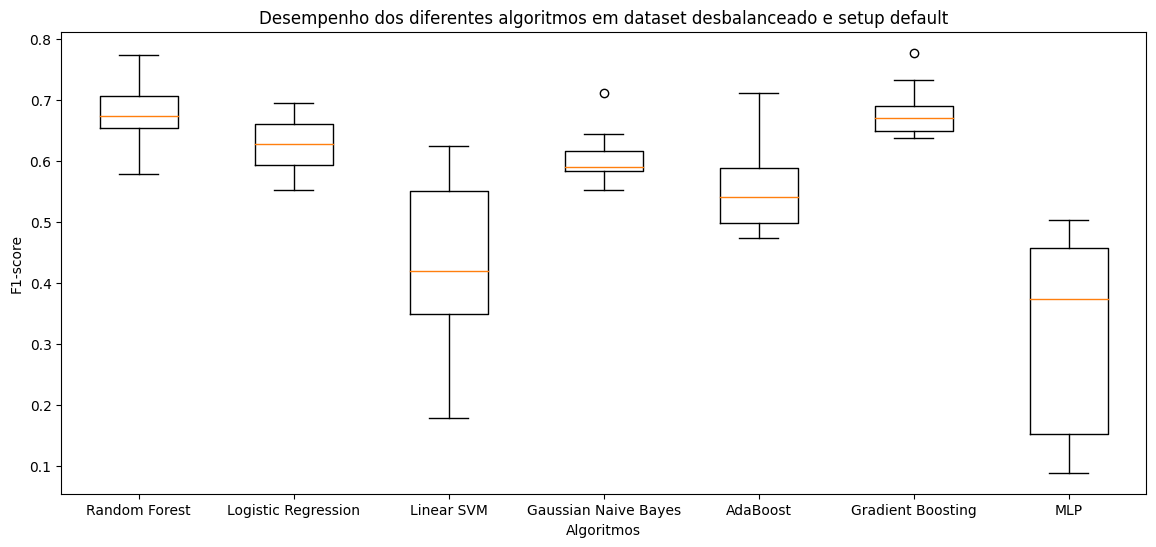

In [ ]:
rf = df_default_transposto['Random Forest']
lr = df_default_transposto['Logistic Regression']
svm = df_default_transposto['Linear SVM']
nb = df_default_transposto['Gaussian Naive Bayes']
ab = df_default_transposto['AdaBoost']
gb = df_default_transposto['Gradient Boosting']
mlp = df_default_transposto['MLP']

algoritmos = ['Random Forest', 'Logistic Regression', 'Linear SVM', 'Gaussian Naive Bayes', 'AdaBoost', 'Gradient Boosting', 'MLP']
resultados = [rf, lr, svm, nb, ab, gb, mlp]

fig = plt.figure(figsize=(14, 6))
plt.boxplot(resultados, labels=algoritmos)

plt.title('Performance of different algorithms in imbalanced data and default setup')
plt.xlabel('Algorithms')
plt.ylabel('F1-score')

plt.show()

Now, let's see the performances over the imbalanced data and tuned setup (with the best tuning we could find).

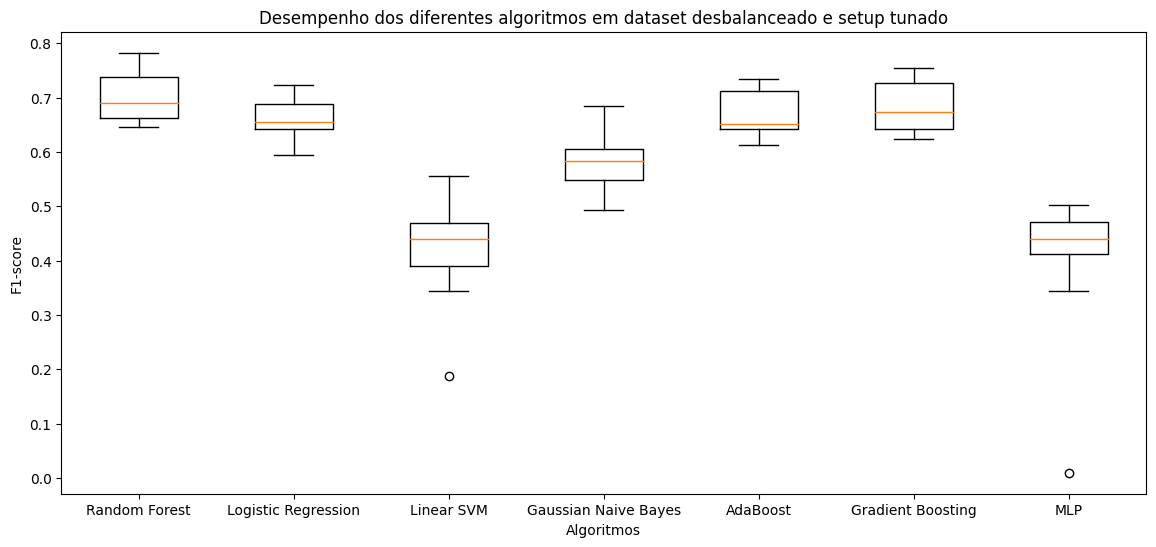

In [ ]:
rf = df_default_tuned_transposto['Random Forest']
lr = df_default_tuned_transposto['Logistic Regression']
svm = df_default_tuned_transposto['Linear SVM']
nb = df_default_tuned_transposto['Gaussian Naive Bayes']
ab = df_default_tuned_transposto['AdaBoost']
gb = df_default_tuned_transposto['Gradient Boosting']
mlp = df_default_tuned_transposto['MLP']

algoritmos = ['Random Forest', 'Logistic Regression', 'Linear SVM', 'Gaussian Naive Bayes', 'AdaBoost', 'Gradient Boosting', 'MLP']
resultados = [rf, lr, svm, nb, ab, gb, mlp]

fig = plt.figure(figsize=(14, 6))
plt.boxplot(resultados, labels=algoritmos)

plt.title('Performance of different algorithms over imbalanced data and tuned setup')
plt.xlabel('Algorithms')
plt.ylabel('F1-score')

plt.show()

Over the balanced data and default setup.

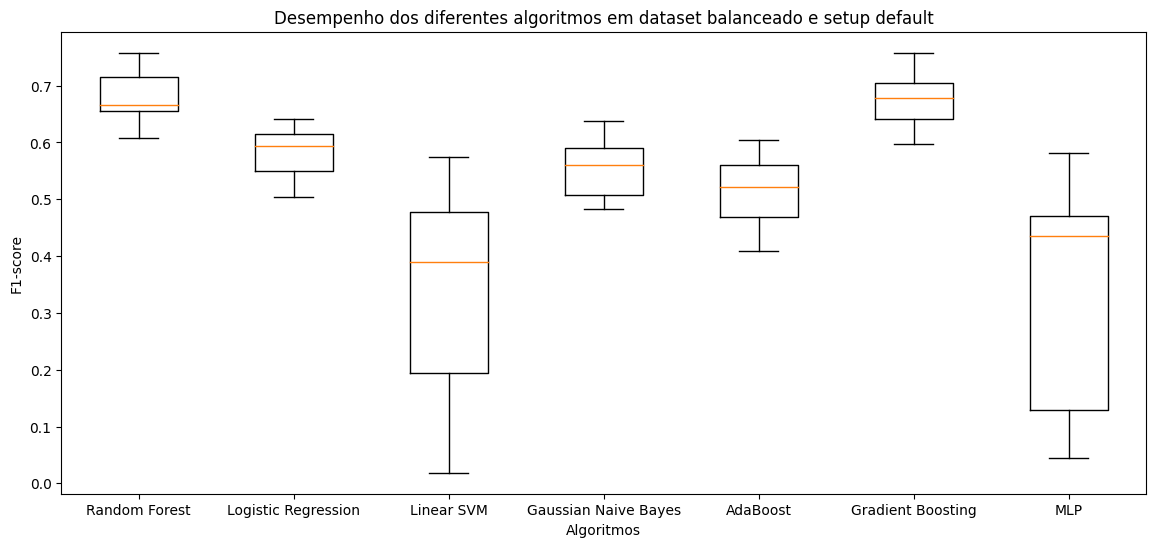

In [ ]:
rf = df_balanced_transposto['Random Forest']
lr = df_balanced_transposto['Logistic Regression']
svm = df_balanced_transposto['Linear SVM']
nb = df_balanced_transposto['Gaussian Naive Bayes']
ab = df_balanced_transposto['AdaBoost']
gb = df_balanced_transposto['Gradient Boosting']
mlp = df_balanced_transposto['MLP']

algoritmos = ['Random Forest', 'Logistic Regression', 'Linear SVM', 'Gaussian Naive Bayes', 'AdaBoost', 'Gradient Boosting', 'MLP']
resultados = [rf, lr, svm, nb, ab, gb, mlp]

fig = plt.figure(figsize=(14, 6))
plt.boxplot(resultados, labels=algoritmos)

plt.title('Performance of different algorithms over balanced data and default setup')
plt.xlabel('Algorithms')
plt.ylabel('F1-score')

plt.show()

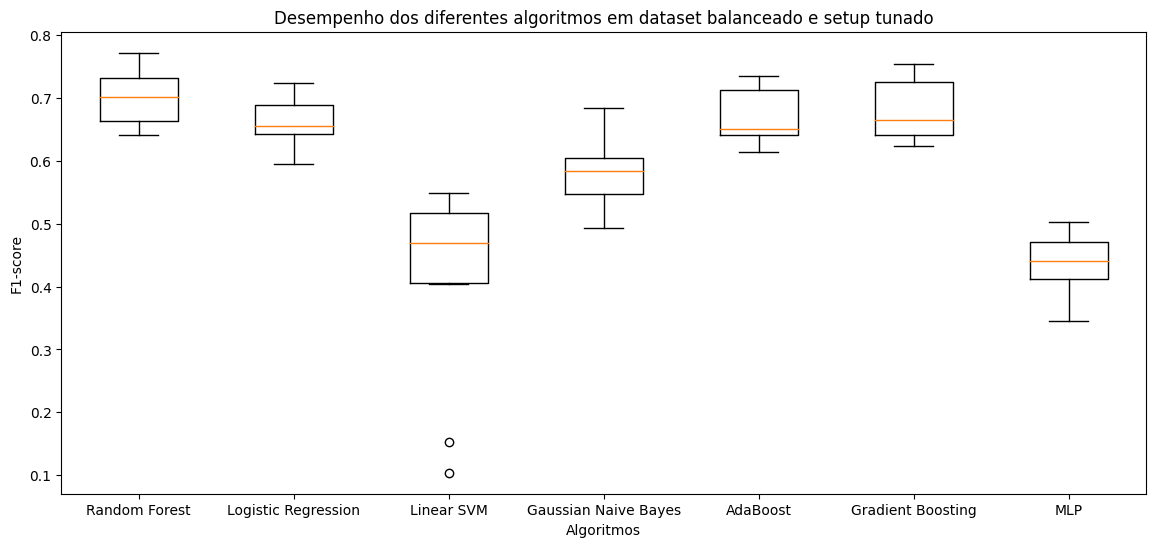

In [ ]:
rf = df_balanced_tuned_transposto['Random Forest']
lr = df_balanced_tuned_transposto['Logistic Regression']
svm = df_balanced_tuned_transposto['Linear SVM']
nb = df_balanced_tuned_transposto['Gaussian Naive Bayes']
ab = df_balanced_tuned_transposto['AdaBoost']
gb = df_balanced_tuned_transposto['Gradient Boosting']
mlp = df_balanced_tuned_transposto['MLP']

algoritmos = ['Random Forest', 'Logistic Regression', 'Linear SVM', 'Gaussian Naive Bayes', 'AdaBoost', 'Gradient Boosting', 'MLP']
resultados = [rf, lr, svm, nb, ab, gb, mlp]

fig = plt.figure(figsize=(14, 6))
plt.boxplot(resultados, labels=algoritmos)

plt.title('Performance of different algorithms over balanced data and tuned setup')
plt.xlabel('Algorithms')
plt.ylabel('F1-score')

plt.show()

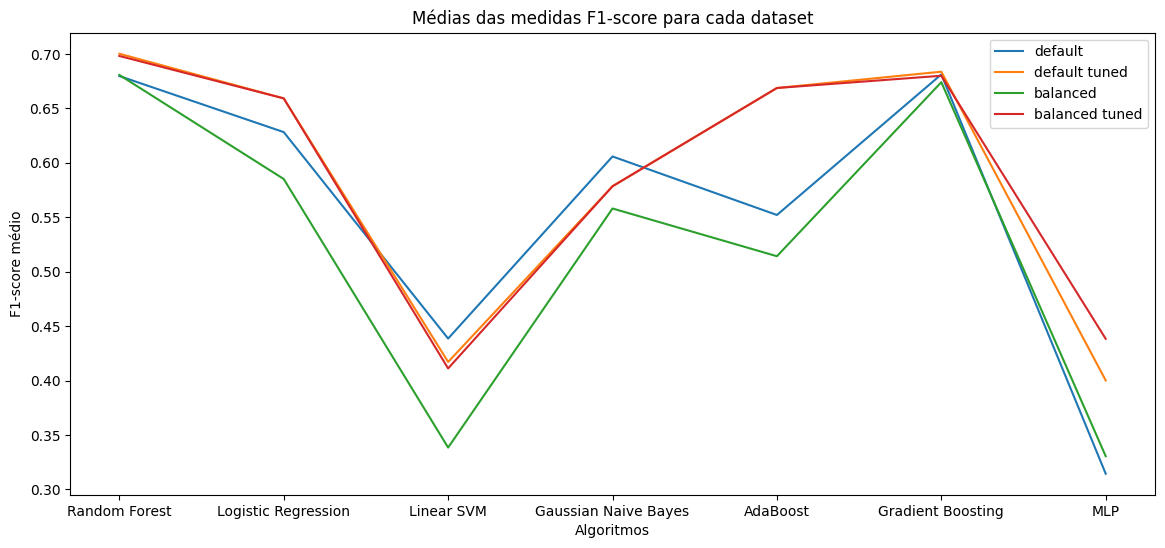

In [ ]:
lista_medias = []

for df in [df_default_transposto, df_default_tuned_transposto, df_balanced_transposto, df_balanced_tuned_transposto]:
    df_medias = df.mean()
    lista_medias.append(df_medias)

df_combined_medias = pandas.concat(lista_medias, axis=1)

datasets = ['default', 'default tuned', 'balanced', 'balanced tuned']

fig = plt.figure(figsize=(14, 6))
plt.plot(df_combined_medias)

plt.xlabel('Algorithms')
plt.ylabel('F1-score (mean)')
plt.title('Mean of F1-score metric over each dataset')
plt.legend(datasets)

plt.show()

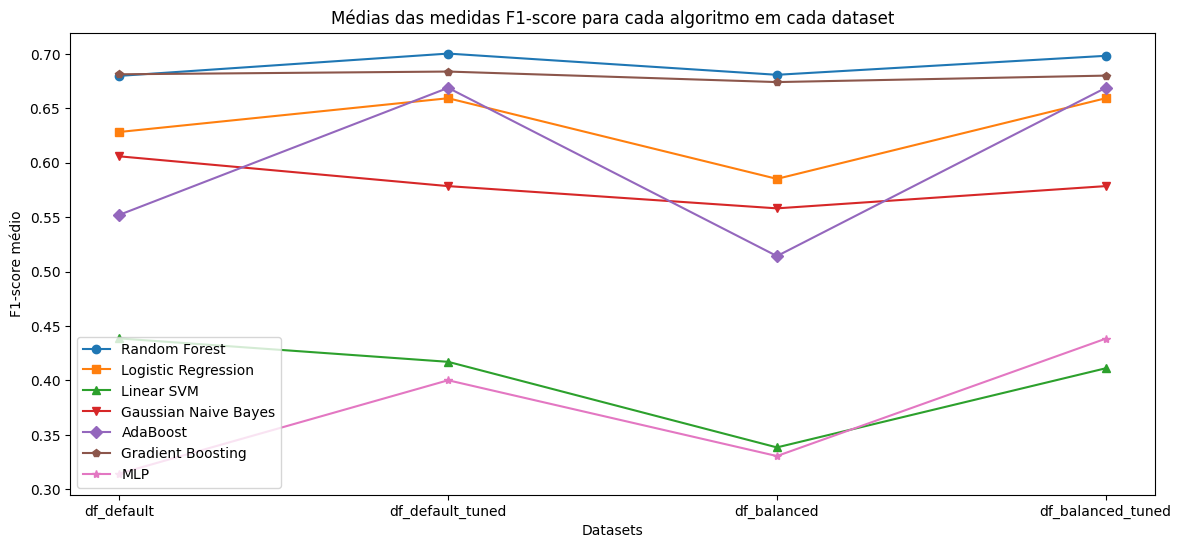

In [ ]:
import matplotlib.pyplot as plt

lista_medias = []

for df in [df_default_transposto, df_default_tuned_transposto, df_balanced_transposto, df_balanced_tuned_transposto]:
    df_medias = df.mean()
    lista_medias.append(df_medias)

df_combined_medias = pandas.concat(lista_medias, axis=1)

nomes_dataframes = ['df_default', 'df_default_tuned', 'df_balanced', 'df_balanced_tuned']
#cores = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
marcadores = ['o', 's', '^', 'v', 'D', 'p', '*']

fig = plt.figure(figsize=(14, 6))

for i, algoritmo in enumerate(df_combined_medias.index):
    valores = df_combined_medias.loc[algoritmo]
    plt.plot(nomes_dataframes, valores, label=algoritmo, marker=marcadores[i])

plt.xlabel('Datasets')
plt.ylabel('F1-score (mean)')
plt.legend(loc='lower left')
plt.title('Mean of the F1-score metric for each algorithm over each dataset')
plt.show()

To find the better model to solve this problem, we will need a deeper analysis. One interesting analysis we can perform is a statistical test, looking for statistical differences between the models.

For this, the commonly used is the Align-Friedman test, a statistical technique also used - among many other purposes - to compare the performance of machine learning models. It's a non-parametric test, applied to data that doesn't perform over a normal distribution (our case). With the Align-Friedman test, we can interpret the *p-value* to determine whether there is a statistically significant difference between the models developed to solve the referred problem.

The Align-Friedman test uses the following null and alternative hypotheses:

* The null hypothesis (H0): the models performance are equal;
* The alternative hypothesis (Ha): at least one model performance is statiscally different from the others.

If the *p-value* is less than a predetermined significance level (usually 5%, or 0.05), the null hypothesis (that the models are equal, by they performance) can be rejected, and thus we can conclude that at least one of the models that was developed is significantly better than the others. Otherwise, the null hypothesis cannot be rejected - this means concluding that all models performed similarly. The statistic generated by the test is a measure of how different the compared models are in terms of their average overall rating across all evaluation metrics.

So, let's apply this test.

In [ ]:
print("Teste de Friedman em dataset desbalanceado e setup default: ")
pg.friedman(df_f1_default)

Teste de Friedman em dataset desbalanceado e setup default: 


,Source,W,ddof1,Q,p-unc
Friedman,Within,0.366923,9,23.116118,0.005941


In [ ]:
print("Teste de Friedman em dataset desbalanceado e setup tunado: ")
pg.friedman(df_f1_default_tuned)

Teste de Friedman em dataset desbalanceado e setup tunado: 


,Source,W,ddof1,Q,p-unc
Friedman,Within,0.517267,9,32.587826,0.000158


In [ ]:
print("Teste de Friedman em dataset balanceado e setup default: ")
pg.friedman(df_f1_balanced)

Teste de Friedman em dataset balanceado e setup default: 


,Source,W,ddof1,Q,p-unc
Friedman,Within,0.33457,9,21.077922,0.012309


In [ ]:
print("Teste de Friedman em dataset balanceado e setup tunado: ")
pg.friedman(df_f1_balanced_tuned)

Teste de Friedman em dataset balanceado e setup tunado: 


,Source,W,ddof1,Q,p-unc
Friedman,Within,0.404245,9,25.46742,0.002495


As we can see above, a low p-value, as is the case over all the datasets, indicates that it is highly unlikely that the observed result occurred by chance, reinforcing the evidence against the null hypothesis and in favor of the alternative hypothesis. Therefore, we can reject the null hypothesis and conclude that there is a significant difference between the tested models.

Now it's time to find the best model.

Let's apply the Holm's post hoc test and build a ranking over the algorithm's performances.

(I couldn't find the Holm's test in Python, so I exported the data and applied to an external website, link here: )

As result, we got the table below:

MODEL | F1-SCORE (mean)
--- | ---
Random Forest | 6.50
Gradient Boosting | 6.30
Logistic Regression | 4.50
Gaussian Naive Bayes | 4.00
AdaBoost | 3.30
Linear SVM | 2.05
MLP | 1.35

This result shows to us that Random Forest is the indicated algorithm to handle with this problem.

In [ ]:
f1_default = {1: {'Random Forest': 0.6872303206997085,
  'Logistic Regression': 0.5900521833267083,
  'Linear SVM': 0.3620466824686302,
  'Gaussian Naive Bayes': 0.584828079396728,
  'AdaBoost': 0.5096969696969698,
  'Gradient Boosting': 0.6371816638370119,
  'MLP': 0.44226053713822333},
 10: {'Random Forest': 0.5788929978049764,
  'Logistic Regression': 0.5527070332265138,
  'Linear SVM': 0.3993973428297493,
  'Gaussian Naive Bayes': 0.5934230835191219,
  'AdaBoost': 0.5299363266100736,
  'Gradient Boosting': 0.6650502824080451,
  'MLP': 0.1520329061857301},
 100: {'Random Forest': 0.6455718658072218,
  'Logistic Regression': 0.6414021164021164,
  'Linear SVM': 0.33983706981947576,
  'Gaussian Naive Bayes': 0.6083116971024373,
  'AdaBoost': 0.4739205886436207,
  'Gradient Boosting': 0.6428911187116356,
  'MLP': 0.0892224658458425},
 500: {'Random Forest': 0.6979180683262317,
  'Logistic Regression': 0.6401288936627283,
  'Linear SVM': 0.5510204081632653,
  'Gaussian Naive Bayes': 0.6193470382365557,
  'AdaBoost': 0.4947667564148119,
  'Gradient Boosting': 0.6790287543588864,
  'MLP': 0.5031055900621119},
 1000: {'Random Forest': 0.6593357039785611,
  'Logistic Regression': 0.5877750367546287,
  'Linear SVM': 0.3447324875896305,
  'Gaussian Naive Bayes': 0.573429009519235,
  'AdaBoost': 0.4878780870146223,
  'Gradient Boosting': 0.6698412698412699,
  'MLP': 0.3447324875896305},
 10000: {'Random Forest': 0.7741828438692551,
  'Logistic Regression': 0.6944357230071516,
  'Linear SVM': 0.6238859885039286,
  'Gaussian Naive Bayes': 0.5838635049161365,
  'AdaBoost': 0.710989010989011,
  'Gradient Boosting': 0.732163984623125,
  'MLP': 0.1520329061857301},
 50000: {'Random Forest': 0.7339935974389756,
  'Logistic Regression': 0.6882957041571633,
  'Linear SVM': 0.17872603586889302,
  'Gaussian Naive Bayes': 0.7112730806608358,
  'AdaBoost': 0.5515873015873016,
  'Gradient Boosting': 0.7774395472474703,
  'MLP': 0.4625850340136054},
 100000: {'Random Forest': 0.7100380977223185,
  'Logistic Regression': 0.667055393586006,
  'Linear SVM': 0.5952858001545639,
  'Gaussian Naive Bayes': 0.5522777777777778,
  'AdaBoost': 0.5991514340460478,
  'Gradient Boosting': 0.69325492909028,
  'MLP': 0.4757571818536332},
 500000: {'Random Forest': 0.6538113160023443,
  'Logistic Regression': 0.6164502164502165,
  'Linear SVM': 0.5495694781409067,
  'Gaussian Naive Bayes': 0.6443246194798989,
  'AdaBoost': 0.5546490070047108,
  'Gradient Boosting': 0.6426456050400455,
  'MLP': 0.4034947312258237},
 1000000: {'Random Forest': 0.6564309093925819,
  'Logistic Regression': 0.6037682789651294,
  'Linear SVM': 0.4412244897959184,
  'Gaussian Naive Bayes': 0.587329931972789,
  'AdaBoost': 0.6083181172651653,
  'Gradient Boosting': 0.6724784527394094,
  'MLP': 0.11902040816326528}}

f1_default_tuned = {1: {'Random Forest': 0.6885645105499828,
  'Logistic Regression': 0.6664580461276927,
  'Linear SVM': 0.47027506654835854,
  'Gaussian Naive Bayes': 0.5797811235368349,
  'AdaBoost': 0.6830583105796524,
  'Gradient Boosting': 0.6993745885450954,
  'MLP': 0.45248927596516314},
 10: {'Random Forest': 0.6931337752492301,
  'Logistic Regression': 0.6079884679121927,
  'Linear SVM': 0.3915145005370569,
  'Gaussian Naive Bayes': 0.5574037133650452,
  'AdaBoost': 0.6414959239336697,
  'Gradient Boosting': 0.6506793698911926,
  'MLP': 0.009523809523809525},
 100: {'Random Forest': 0.6574846975296921,
  'Logistic Regression': 0.6663935647251601,
  'Linear SVM': 0.18749409182097954,
  'Gaussian Naive Bayes': 0.609947194506974,
  'AdaBoost': 0.613628502248357,
  'Gradient Boosting': 0.6510049339070713,
  'MLP': 0.49030612244897964},
 500: {'Random Forest': 0.6677551020408163,
  'Logistic Regression': 0.6449928808732796,
  'Linear SVM': 0.5556622649059624,
  'Gaussian Naive Bayes': 0.6228127614682237,
  'AdaBoost': 0.6441930037617369,
  'Gradient Boosting': 0.6404614019520851,
  'MLP': 0.5031055900621119},
 1000: {'Random Forest': 0.6605144518240864,
  'Logistic Regression': 0.5946991783726479,
  'Linear SVM': 0.3447324875896305,
  'Gaussian Naive Bayes': 0.4929879036399693,
  'AdaBoost': 0.6425250234774044,
  'Gradient Boosting': 0.6236264243389564,
  'MLP': 0.3447324875896305},
 10000: {'Random Forest': 0.7520825491383402,
  'Logistic Regression': 0.7064571860490227,
  'Linear SVM': 0.4400837257980115,
  'Gaussian Naive Bayes': 0.5448212367653827,
  'AdaBoost': 0.7344814584694143,
  'Gradient Boosting': 0.7490881220909417,
  'MLP': 0.4400837257980115},
 50000: {'Random Forest': 0.7827167396639021,
  'Logistic Regression': 0.7235728187037845,
  'Linear SVM': 0.46501457725947526,
  'Gaussian Naive Bayes': 0.6846117757447806,
  'AdaBoost': 0.7291833747348729,
  'Gradient Boosting': 0.75427388346643,
  'MLP': 0.4400837257980115},
 100000: {'Random Forest': 0.7609059771397434,
  'Logistic Regression': 0.6954711223967313,
  'Linear SVM': 0.4855596784168213,
  'Gaussian Naive Bayes': 0.5162001559517088,
  'AdaBoost': 0.721959776646736,
  'Gradient Boosting': 0.7351327627825324,
  'MLP': 0.47760236169939674},
 500000: {'Random Forest': 0.6457702698304202,
  'Logistic Regression': 0.6415125919148413,
  'Linear SVM': 0.39041703637976927,
  'Gaussian Naive Bayes': 0.588916797488226,
  'AdaBoost': 0.617993676343777,
  'Gradient Boosting': 0.6385882288137927,
  'MLP': 0.4034947312258237},
 1000000: {'Random Forest': 0.6932701652089406,
  'Logistic Regression': 0.6444577831132453,
  'Linear SVM': 0.4400837257980115,
  'Gaussian Naive Bayes': 0.587329931972789,
  'AdaBoost': 0.6588773605949978,
  'Gradient Boosting': 0.6948724744643111,
  'MLP': 0.4400837257980115}}

f1_balanced = {1: {'Random Forest': 0.6599618473778798,
  'Logistic Regression': 0.5764163921598324,
  'Linear SVM': 0.5738002478890167,
  'Gaussian Naive Bayes': 0.5009315306351261,
  'AdaBoost': 0.455271098482067,
  'Gradient Boosting': 0.6978466498372821,
  'MLP': 0.11700449083626654},
 10: {'Random Forest': 0.6086272719598028,
  'Logistic Regression': 0.5036674957064166,
  'Linear SVM': 0.4385148285035799,
  'Gaussian Naive Bayes': 0.4837444305662566,
  'AdaBoost': 0.5115281827016522,
  'Gradient Boosting': 0.5970196529315952,
  'MLP': 0.04429847286990144},
 100: {'Random Forest': 0.6531140508597015,
  'Logistic Regression': 0.6373294673060481,
  'Linear SVM': 0.18121751806312586,
  'Gaussian Naive Bayes': 0.5892083490028643,
  'AdaBoost': 0.5145168067226891,
  'Gradient Boosting': 0.6738474593945408,
  'MLP': 0.4804959958667011},
 500: {'Random Forest': 0.6683647102251754,
  'Logistic Regression': 0.6157861213983663,
  'Linear SVM': 0.5740515060776039,
  'Gaussian Naive Bayes': 0.6377426832802086,
  'AdaBoost': 0.5629888318963949,
  'Gradient Boosting': 0.6783451271748425,
  'MLP': 0.5031055900621119},
 1000: {'Random Forest': 0.693288465066823,
  'Logistic Regression': 0.6132701384973209,
  'Linear SVM': 0.34231523117721663,
  'Gaussian Naive Bayes': 0.5259387069497452,
  'AdaBoost': 0.42849501599825685,
  'Gradient Boosting': 0.6776051329622756,
  'MLP': 0.1638969873663751},
 10000: {'Random Forest': 0.7514662992176587,
  'Logistic Regression': 0.5982909982626254,
  'Linear SVM': 0.018690129112869637,
  'Gaussian Naive Bayes': 0.5523623382062584,
  'AdaBoost': 0.5277486488666613,
  'Gradient Boosting': 0.7580133748414621,
  'MLP': 0.43870415298986737},
 50000: {'Random Forest': 0.7571164612883956,
  'Logistic Regression': 0.6408643801500944,
  'Linear SVM': 0.09247448979591838,
  'Gaussian Naive Bayes': 0.6359484648827323,
  'AdaBoost': 0.6050127692272922,
  'Gradient Boosting': 0.721637546127342,
  'MLP': 0.43265306122448977},
 100000: {'Random Forest': 0.722846765824974,
  'Logistic Regression': 0.5359441915179084,
  'Linear SVM': 0.23434306948845507,
  'Gaussian Naive Bayes': 0.4938565979201702,
  'AdaBoost': 0.5543046439085749,
  'Gradient Boosting': 0.7061447893642017,
  'MLP': 0.43735645734545425},
 500000: {'Random Forest': 0.6292389136105572,
  'Logistic Regression': 0.5397866009953339,
  'Linear SVM': 0.48912300888137794,
  'Gaussian Naive Bayes': 0.5911745189673446,
  'AdaBoost': 0.572759538598048,
  'Gradient Boosting': 0.5991171286916704,
  'MLP': 0.582089552238806},
 1000000: {'Random Forest': 0.6632551272906316,
  'Logistic Regression': 0.5899467806762639,
  'Linear SVM': 0.4400837257980115,
  'Gaussian Naive Bayes': 0.5696112091453123,
  'AdaBoost': 0.4095094880057287,
  'Gradient Boosting': 0.6308469382018281,
  'MLP': 0.10566512319213399}}

f1_balanced_tuned = {1: {'Random Forest': 0.6993745885450954,
  'Logistic Regression': 0.6664580461276927,
  'Linear SVM': 0.5497353303737602,
  'Gaussian Naive Bayes': 0.5797811235368349,
  'AdaBoost': 0.6830583105796524,
  'Gradient Boosting': 0.6858641120519399,
  'MLP': 0.45248927596516314},
 10: {'Random Forest': 0.6638114844496728,
  'Logistic Regression': 0.6079884679121927,
  'Linear SVM': 0.1520329061857301,
  'Gaussian Naive Bayes': 0.5574037133650452,
  'AdaBoost': 0.6414959239336697,
  'Gradient Boosting': 0.6442206192821955,
  'MLP': 0.3915145005370569},
 100: {'Random Forest': 0.6447472170686457,
  'Logistic Regression': 0.6663935647251601,
  'Linear SVM': 0.521083650851645,
  'Gaussian Naive Bayes': 0.609947194506974,
  'AdaBoost': 0.613628502248357,
  'Gradient Boosting': 0.6410418935728273,
  'MLP': 0.49030612244897964},
 500: {'Random Forest': 0.664625850340136,
  'Logistic Regression': 0.6449928808732796,
  'Linear SVM': 0.5281414452573483,
  'Gaussian Naive Bayes': 0.6228127614682237,
  'AdaBoost': 0.6441930037617369,
  'Gradient Boosting': 0.6404614019520851,
  'MLP': 0.5031055900621119},
 1000: {'Random Forest': 0.7161058061165472,
  'Logistic Regression': 0.5946991783726479,
  'Linear SVM': 0.49984225060529697,
  'Gaussian Naive Bayes': 0.4929879036399693,
  'AdaBoost': 0.6425250234774044,
  'Gradient Boosting': 0.6236264243389564,
  'MLP': 0.3447324875896305},
 10000: {'Random Forest': 0.7369614512471656,
  'Logistic Regression': 0.7064571860490227,
  'Linear SVM': 0.1038453485937609,
  'Gaussian Naive Bayes': 0.5448212367653827,
  'AdaBoost': 0.7344814584694143,
  'Gradient Boosting': 0.7417547376093295,
  'MLP': 0.4400837257980115},
 50000: {'Random Forest': 0.772185710442369,
  'Logistic Regression': 0.7235728187037845,
  'Linear SVM': 0.4400837257980115,
  'Gaussian Naive Bayes': 0.6846117757447806,
  'AdaBoost': 0.7291833747348729,
  'Gradient Boosting': 0.75427388346643,
  'MLP': 0.4400837257980115},
 100000: {'Random Forest': 0.7380952380952381,
  'Logistic Regression': 0.6954711223967313,
  'Linear SVM': 0.5022541743970316,
  'Gaussian Naive Bayes': 0.5162001559517088,
  'AdaBoost': 0.721959776646736,
  'Gradient Boosting': 0.7351327627825324,
  'MLP': 0.47760236169939674},
 500000: {'Random Forest': 0.6416606168158963,
  'Logistic Regression': 0.6415125919148413,
  'Linear SVM': 0.4034947312258237,
  'Gaussian Naive Bayes': 0.588916797488226,
  'AdaBoost': 0.617993676343777,
  'Gradient Boosting': 0.6385882288137927,
  'MLP': 0.4034947312258237},
 1000000: {'Random Forest': 0.7040608664518438,
  'Logistic Regression': 0.6444577831132453,
  'Linear SVM': 0.4110204081632653,
  'Gaussian Naive Bayes': 0.587329931972789,
  'AdaBoost': 0.6588773605949978,
  'Gradient Boosting': 0.6948724744643111,
  'MLP': 0.4400837257980115}}